In [11]:
import os
import traceback
from datetime import datetime
import uuid
import chromadb
from dotenv import load_dotenv
from typing import Annotated, Union
from typing_extensions import TypedDict

from functools import partial
from typing import Annotated, Sequence, TypedDict
import operator

from pydantic import BaseModel

from langchain.tools import StructuredTool
from langchain_core.messages import ToolMessage
from langchain_core.language_models import BaseLanguageModel
from langgraph.graph import StateGraph, START, END
from langchain.schema import BaseMessage
from langgraph.prebuilt import ToolExecutor, ToolInvocation
from langchain_core.tools import tool


from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph
from langchain_ollama import ChatOllama
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.documents import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.base import format_document
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    BaseMessage,
    get_buffer_string,
)
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate


from IPython.display import Image, display

In [12]:
load_dotenv()

True

In [13]:
llm = ChatOpenAI(model="gpt-4o", api_key=os.getenv("OPENAI_API_KEY"))
fast_llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))
local_llm = ChatOllama(model="llama3.1", temperature=0)
local_embedding_model = OllamaEmbeddings(model="nomic-embed-text:latest")

In [ ]:
@tool
async def test_tool(input: Annotated[str, "This is a test tool"]):
    """This is a test tool"""
    return f"This is a test tool: {input}"

In [14]:
local_llm.bind_tools([test_tool])
init_msg = [HumanMessage(content="Hello")]
await local_llm.ainvoke("hello")

AIMessage(content='Hello! How are you today? Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-09-29T01:32:01.677395Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 8230483042, 'load_duration': 7349574084, 'prompt_eval_count': 11, 'prompt_eval_duration': 220007000, 'eval_count': 23, 'eval_duration': 657364000}, id='run-27cae112-d2c8-4db4-a358-3f2b400e0a13-0', usage_metadata={'input_tokens': 11, 'output_tokens': 23, 'total_tokens': 34})

In [15]:
from typing import Union, Protocol


class ToolCallingLanguageModel(Protocol):
    def bind_tools(self, tools: list[StructuredTool]) -> None: ...

    async def ainvoke(self, messages: list[BaseMessage]) -> BaseMessage: ...


ToolCallingLanguageModel = Union[ChatOpenAI, ChatOllama]

In [16]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


def should_continue(state: AgentState) -> bool:
    return "continue" if state.get("messages", [])[-1].tool_calls else "end"


async def agent(model: BaseLanguageModel, state: AgentState) -> AgentState:
    return {"messages": [await model.ainvoke(state["messages"])]}


async def action(executor: ToolExecutor, state: AgentState) -> AgentState:
    return {
        "messages": [
            ToolMessage(
                tool_call_id=(tool_call := state["messages"][-1]).tool_calls[0].id,
                name=(
                    action := ToolInvocation(
                        tool=tool_call.get("name"), tool_input=tool_call["args"]
                    )
                ).tool,
                content=str(await executor.ainvoke(action)),
            )
        ]
    }


class ChatGraph(BaseModel):
    graph: CompiledStateGraph

    @classmethod
    def from_dependencies(
        cls,
        llm: ToolCallingLanguageModel,
        tools: list[StructuredTool],
    ) -> "ChatGraph":
        graph = StateGraph(AgentState)
        graph.add_node("agent", partial(agent, llm.bind_tools(tools)))
        graph.add_node("action", partial(action, ToolExecutor(tools)))
        graph.add_edge(START, "agent")
        graph.add_conditional_edges(
            "agent", should_continue, path_map={"continue": "action", "end": END}
        )
        graph.add_edge("action", "agent")
        return graph.compile()

PydanticSchemaGenerationError: Unable to generate pydantic-core schema for <class 'langgraph.graph.state.CompiledStateGraph'>. Set `arbitrary_types_allowed=True` in the model_config to ignore this error or implement `__get_pydantic_core_schema__` on your type to fully support it.

If you got this error by calling handler(<some type>) within `__get_pydantic_core_schema__` then you likely need to call `handler.generate_schema(<some type>)` since we do not call `__get_pydantic_core_schema__` on `<some type>` otherwise to avoid infinite recursion.

For further information visit https://errors.pydantic.dev/2.8/u/schema-for-unknown-type

In [ ]:
chat_graph = ChatGraph.from_dependencies(llm=local_llm, tools=[test_tool])

/var/folders/k9/fclgtm1j483d4r4tbjfzpz1w0000gn/T/ipykernel_96144/1195976216.py:40: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  graph.add_node("action", partial(action, ToolExecutor(tools)))


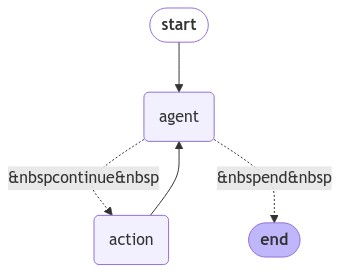

In [ ]:
def draw_graph(graph: CompiledStateGraph):
    display(Image(graph.get_graph().draw_mermaid_png()))

draw_graph(chat_graph)

In [ ]:
init_msg = [HumanMessage(content="Hello")]
async for event in chat_graph.astream({"messages": init_msg}):
    async for value in event.values():
        print(value)

AttributeError: 'ModelPrivateAttr' object has no attribute 'chat'